**SETUP**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from alpha_vantage.fundamentaldata import FundamentalData
import yfinance as yf
from scipy.stats import norm
from scipy.stats import truncnorm


# Configurar claves y empresa
api_key = 'LFQQIV3LD5O20Q7P'
api_key_fmp = 'SW7iWJC4lOhllC0XBJehTs2MY7lNyNvk'
ticker = 'BHP'
fd = FundamentalData(key=api_key, output_format='pandas')
empresa_yf = yf.Ticker(ticker)


Descarga datos financieros

In [2]:
# Descargar estados financieros anuales
income_stmt, _ = fd.get_income_statement_annual(ticker)
balance_sheet, _ = fd.get_balance_sheet_annual(ticker)
cash_flow, _ = fd.get_cash_flow_annual(ticker)

# Configurar índices por fecha
income_stmt.set_index("fiscalDateEnding", inplace=True)
balance_sheet.set_index("fiscalDateEnding", inplace=True)
cash_flow.set_index("fiscalDateEnding", inplace=True)
fechas = income_stmt.index.intersection(balance_sheet.index).intersection(cash_flow.index)

Calculo KPIs

In [3]:
# Inicializar diccionario de KPIs
kpis = {
    "Total Revenue": [], "Net Income": [], "EBIT": [],
    "Total Assets": [], "Total Equity": [], "Total Debt": [],
    "Operating Cash Flow": [], "CapEx": [], "Free Cash Flow": [],
    "Margen Neto": [], "Margen EBIT": [], "ROE": [], "ROA": [],
    "Deuda / Activos": [], "Deuda / EBIT": [], "FCF / Ingresos": []
}

# Fechas comunes
fechas = income_stmt.index.intersection(balance_sheet.index).intersection(cash_flow.index)

# Cálculo de KPIs por año
for fecha in fechas:
    try:
        rev = float(income_stmt.loc[fecha]["totalRevenue"])
        ni = float(income_stmt.loc[fecha]["netIncome"])
        ebit = float(income_stmt.loc[fecha].get("ebit", income_stmt.loc[fecha].get("operatingIncome", 0)))
        assets = float(balance_sheet.loc[fecha]["totalAssets"])
        equity = float(balance_sheet.loc[fecha]["totalShareholderEquity"])
        debt = float(balance_sheet.loc[fecha]["totalLiabilities"])
        ocf = float(cash_flow.loc[fecha]["operatingCashflow"])
        capex = float(cash_flow.loc[fecha]["capitalExpenditures"])
        fcf = ocf - capex

        kpis["Total Revenue"].append(rev)
        kpis["Net Income"].append(ni)
        kpis["EBIT"].append(ebit)
        kpis["Total Assets"].append(assets)
        kpis["Total Equity"].append(equity)
        kpis["Total Debt"].append(debt)
        kpis["Operating Cash Flow"].append(ocf)
        kpis["CapEx"].append(capex)
        kpis["Free Cash Flow"].append(fcf)
        kpis["Margen Neto"].append(ni / rev)
        kpis["Margen EBIT"].append(ebit / rev)
        kpis["ROE"].append(ni / equity)
        kpis["ROA"].append(ni / assets)
        kpis["Deuda / Activos"].append(debt / assets)
        kpis["Deuda / EBIT"].append(debt / ebit)
        kpis["FCF / Ingresos"].append(fcf / rev)

    except Exception as e:
        print(f"Error en {fecha}: {e}")
        for key in kpis:
            kpis[key].append(None)

# Convertir a DataFrame ordenado
df_kpis = pd.DataFrame(kpis, index=fechas).sort_index(ascending=False).round(2)
df_kpis.head()


,Total Revenue,Net Income,EBIT,Total Assets,Total Equity,Total Debt,Operating Cash Flow,CapEx,Free Cash Flow,Margen Neto,Margen EBIT,ROE,ROA,Deuda / Activos,Deuda / EBIT,FCF / Ingresos
fiscalDateEnding,,,,,,,,,,,,,,,,
2024-06-30,5.602700e+10,7.897000e+09,1.823000e+10,1.023620e+11,4.481100e+10,5.324200e+10,2.066500e+10,8.816000e+09,1.184900e+10,0.14,0.33,0.18,0.08,0.52,2.92,0.21
2023-06-30,5.381700e+10,1.292100e+10,2.206000e+10,1.012960e+11,4.305500e+10,5.276600e+10,1.870100e+10,6.733000e+09,1.196800e+10,0.24,0.41,0.30,0.13,0.52,2.39,0.22
2022-06-30,6.509800e+10,2.274100e+10,3.295300e+10,9.516600e+10,4.497600e+10,4.640000e+10,3.217400e+10,6.111000e+09,2.606300e+10,0.35,0.51,0.51,0.24,0.49,1.41,0.40
2021-06-30,5.692100e+10,1.130400e+10,2.515000e+10,1.089270e+11,5.126400e+10,5.332200e+10,2.723400e+10,5.612000e+09,2.162200e+10,0.20,0.44,0.22,0.10,0.49,2.12,0.38
2020-06-30,4.293100e+10,7.956000e+09,1.337900e+10,1.047830e+11,4.793600e+10,5.253700e+10,1.570600e+10,6.900000e+09,8.806000e+09,0.19,0.31,0.17,0.08,0.50,3.93,0.21


Supuestos

In [4]:
# Definir tipo de empresa
tipo_empresa = "estable"  # Opciones: "estable", "ciclica", "global", "tech_madura"

# Asignar supuestos según el tipo
if tipo_empresa == "estable":
    margen_ebit = df_kpis["Margen EBIT"].mean()
    capex_ratio = (df_kpis["CapEx"] / df_kpis["Total Revenue"]).mean()
    depr_ratio = 0.04
    nwc_ratio = 0.015
    g_perpetuo = 0.025
    coste_equity = 0.09
    coste_deuda = 0.05
    n = 5

elif tipo_empresa == "ciclica":
    margen_ebit = df_kpis["Margen EBIT"].rolling(3).mean().mean()
    capex_ratio = (df_kpis["CapEx"] / df_kpis["Total Revenue"]).mean()
    depr_ratio = 0.045
    nwc_ratio = 0.025
    g_perpetuo = 0.02
    coste_equity = 0.11
    coste_deuda = 0.07
    n = 7  # Para capturar el ciclo

elif tipo_empresa == "global":
    margen_ebit = df_kpis["Margen EBIT"].mean()
    capex_ratio = (df_kpis["CapEx"] / df_kpis["Total Revenue"]).mean()
    depr_ratio = 0.035
    nwc_ratio = 0.018
    g_perpetuo = 0.025
    coste_equity = 0.085
    coste_deuda = 0.055
    n = 5

elif tipo_empresa == "tech_madura":
    margen_ebit = df_kpis["Margen EBIT"].mean() * 1.05  # Posible mejora de márgenes
    capex_ratio = (df_kpis["CapEx"] / df_kpis["Total Revenue"]).mean()
    depr_ratio = 0.03
    nwc_ratio = 0.01
    g_perpetuo = 0.03
    coste_equity = 0.095
    coste_deuda = 0.045
    n = 5

else:
    raise ValueError("Tipo de empresa no reconocido.")


tax_rate = 0.25
ingresos_base = df_kpis["Total Revenue"].dropna().iloc[0]

# Estructura de capital y costos
deuda_sobre_activos = df_kpis["Deuda / Activos"].mean()
equity_sobre_activos = 1 - deuda_sobre_activos
coste_deuda = 0.06
coste_equity = 0.10

# Proyección
proyeccion = []
vp_fcf = []

for i in range(1, n + 1):
    ingresos = ingresos_base * (1 + 0.06)**i
    ebit = ingresos * margen_ebit
    nopat = ebit * (1 - tax_rate)
    depreciation = ingresos * depr_ratio
    capex = ingresos * capex_ratio
    nwc = ingresos * nwc_ratio
    fcf = nopat + depreciation - capex - nwc

    valor_empresa = fcf / 0.09
    deuda = valor_empresa * deuda_sobre_activos
    equity = valor_empresa * equity_sobre_activos
    wacc = (deuda / (deuda + equity)) * coste_deuda * (1 - tax_rate) + (equity / (deuda + equity)) * coste_equity
    vp = fcf / ((1 + wacc) ** i)
    vp_fcf.append(vp)

    proyeccion.append({
        "Año": f"Año {i}",
        "Ingresos": ingresos,
        "EBIT": ebit,
        "NOPAT": nopat,
        "Depreciación": depreciation,
        "CapEx": capex,
        "Cambio NWC": nwc,
        "FCF": fcf,
        "Deuda Proy": deuda,
        "Equity Proy": equity,
        "WACC Ajustado": wacc,
        "VP FCF": vp
    })

# Valor terminal con WACC final
wacc_final = proyeccion[-1]["WACC Ajustado"]
fcf_final = proyeccion[-1]["FCF"]
vt = fcf_final * (1 + g_perpetuo) / (wacc_final - g_perpetuo)
vt_desc = vt / ((1 + wacc_final) ** n)
valor_empresa_total = sum(vp_fcf) + vt_desc

# Consolidar
df_proyeccion = pd.DataFrame(proyeccion).set_index("Año").round(2)
print(f"Valor empresa estimado con WACC ajustado: ${valor_empresa_total:,.0f}")


Valor empresa estimado con WACC ajustado: $169,372,032,000


Analisis de sensitividad

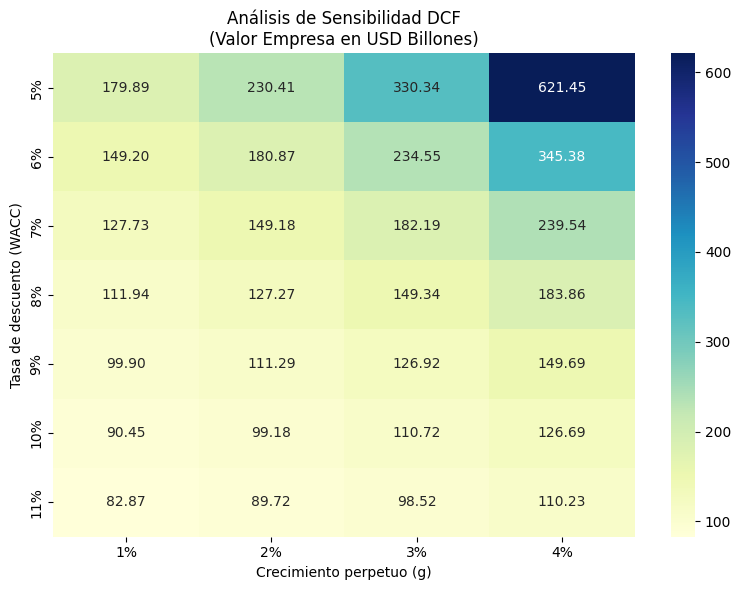

In [5]:
wacc_range = np.arange(wacc_final - 0.02, 0.121, 0.01)
g_range = np.arange(g_perpetuo - 0.02, 0.041, 0.012)

sensibilidad = pd.DataFrame(index=[f"{w*100:.0f}%" for w in wacc_range],
                            columns=[f"{g*100:.0f}%" for g in g_range])

for w in wacc_range:
    for g in g_range:
        if w > g:
            vt = fcf_final * (1 + g) / (w - g)
            vt_desc = vt / ((1 + w)**n)
            valor_total = sum(vp_fcf) + vt_desc
            sensibilidad.loc[f"{w*100:.0f}%", f"{g*100:.0f}%"] = round(valor_total / 1e9, 2)
        else:
            sensibilidad.loc[f"{w*100:.0f}%", f"{g*100:.0f}%"] = np.nan

plt.figure(figsize=(8, 6))
sns.heatmap(sensibilidad.astype(float), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Análisis de Sensibilidad DCF\n(Valor Empresa en USD Billones)")
plt.xlabel("Crecimiento perpetuo (g)")
plt.ylabel("Tasa de descuento (WACC)")
plt.tight_layout()
plt.show()

Monte Carlo Sim

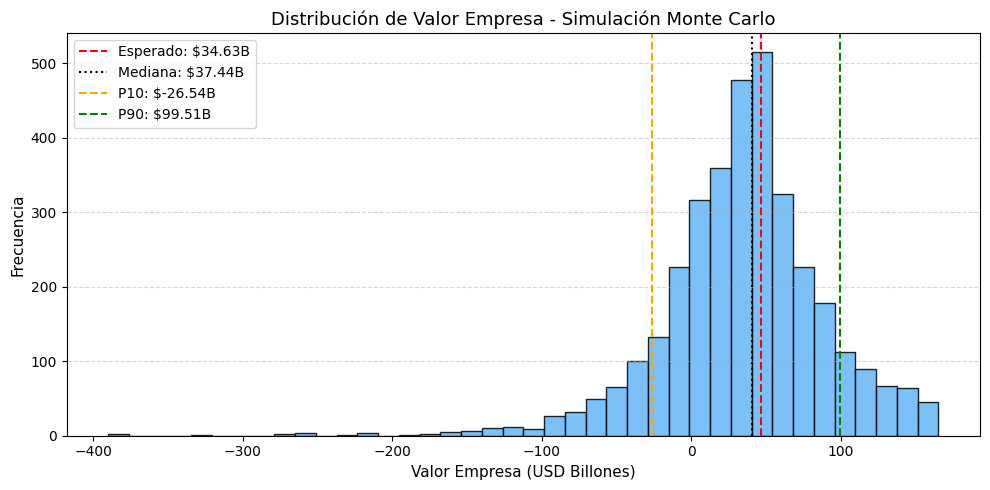

In [6]:
# Calcular parámetros de simulación
media_g = df_kpis["Total Revenue"].pct_change().dropna().mean()
desv_g = df_kpis["Total Revenue"].pct_change().dropna().std()

media_margen = (df_kpis["EBIT"] / df_kpis["Total Revenue"]).mean()
desv_margen = (df_kpis["EBIT"] / df_kpis["Total Revenue"]).std()

media_wacc = wacc_final
std_wacc = 0.01

# Simulación
simulaciones = 5000
resultados = []

def get_truncnorm(mean, std, low, high):
    return truncnorm(
        (low - mean) / std, (high - mean) / std, loc=mean, scale=std
    ).rvs()


for _ in range(simulaciones):
    g = get_truncnorm(media_g, desv_g, -0.02, 0.10)           # crecimiento entre -2% y 10%
    margen = get_truncnorm(media_margen, desv_margen, 0.05, 0.35)  # margen entre 5% y 35%
    wacc = get_truncnorm(media_wacc, std_wacc, 0.06, 0.14)     # WACC entre 6% y 14%

    if wacc - g < 0.01:  # 1% de diferencia mínima
        continue

    fcf_list = []
    for i in range(1, n + 1):
        ingresos = ingresos_base * (1 + g)**i
        ebit = ingresos * margen
        nopat = ebit * (1 - tax_rate)
        depreciation = ingresos * depr_ratio
        capex = ingresos * capex_ratio
        nwc = ingresos * nwc_ratio
        fcf = nopat + depreciation - capex - nwc
        vp = fcf / ((1 + wacc)**i)
        fcf_list.append(vp)

    fcf_final = fcf_list[-1] * ((1 + g) / (wacc - g)) 
    vt_desc = fcf_final / ((1 + wacc)**n)
    valor = sum(fcf_list) + vt_desc
    resultados.append(valor)

# Convertir a Series y visualizar
resultados = pd.Series(resultados)

# Calcular límites usando IQR
q1 = resultados.quantile(0.25)
q3 = resultados.quantile(0.75)
iqr = q3 - q1
umbral_superior = q3 + 1.5 * iqr

# Filtrar datos sin outliers
resultados_filtrados = resultados[resultados <= umbral_superior]

p10 = resultados_filtrados.quantile(0.10) / 1e9
p90 = resultados_filtrados.quantile(0.90) / 1e9

# Visualización
plt.figure(figsize=(10, 5))
plt.hist(resultados_filtrados / 1e9, bins=40, color="#64b5f6", edgecolor="black", alpha=0.85)

# Líneas de referencia
plt.axvline(resultados.mean() / 1e9, color="red", linestyle="--", label=f"Esperado: ${resultados_filtrados.mean()/1e9:.2f}B")
plt.axvline(resultados.median() / 1e9, color="black", linestyle=":", label=f"Mediana: ${resultados_filtrados.median()/1e9:.2f}B")

# Estética
plt.title("Distribución de Valor Empresa - Simulación Monte Carlo", fontsize=13)
plt.xlabel("Valor Empresa (USD Billones)", fontsize=11)
plt.ylabel("Frecuencia", fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.axvline(p10, color="orange", linestyle="--", label=f"P10: ${p10:.2f}B")
plt.axvline(p90, color="green", linestyle="--", label=f"P90: ${p90:.2f}B")
plt.legend()
plt.show()
valor_montecarlo = float(resultados_filtrados.mean())


Comparacion Visual

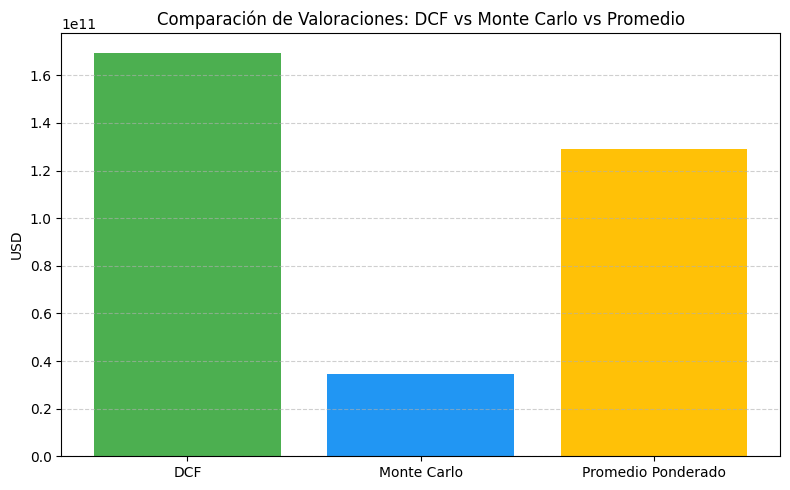

In [7]:
valor_empresa_prom = 0.7 * valor_empresa_total + 0.3 * valor_montecarlo
valores_dict = {
    "DCF": valor_empresa_total,
    "Monte Carlo": valor_montecarlo,
    "Promedio Ponderado": valor_empresa_prom
}

plt.figure(figsize=(8, 5))
plt.bar(valores_dict.keys(), valores_dict.values(), color=["#4CAF50", "#2196F3", "#FFC107"])
plt.ylabel("USD")
plt.title("Comparación de Valoraciones: DCF vs Monte Carlo vs Promedio")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Precio por Accion

In [8]:
valor_montecarlo = resultados.mean()
valor_empresa_total = valor_empresa_total
valor_empresa_prom = (0.4*valor_montecarlo + 0.6*valor_empresa_total)

# Obtener deuda y efectivo actual
try:
    deuda_total = float(balance_sheet.iloc[0]["totalLiabilities"])
    efectivo = float(balance_sheet.iloc[0]["cashAndShortTermInvestments"])
except:
    deuda_total = 0
    efectivo = 0

# Equity value = Enterprise value - Net debt
deuda_neta = deuda_total - efectivo
valor_equity = valor_empresa_prom - deuda_neta

# Acciones en circulación (de Yahoo Finance)
acciones = empresa_yf.info.get("sharesOutstanding")

precio_dcf = (valor_empresa_total - deuda_neta) / acciones if acciones else None
precio_montecarlo = (valor_montecarlo - deuda_neta) / acciones if acciones else None
precio_justo = valor_equity / acciones if acciones else None
precio_actual = empresa_yf.info.get("currentPrice")

# Mostrar resultados
print("\nResumen de Valoración:")
print(f"Valor Empresa DCF: ${valor_empresa_total:,.0f}")
print(f"Valor Empresa Monte Carlo: ${valor_montecarlo:,.0f}")
print(f"Valor Empresa Promedio: ${valor_empresa_prom:,.0f}")
print(f"Valor del Equity Estimado: ${valor_equity:,.0f}")
print(f"Precio por Acción DCF: ${precio_dcf:,.2f}" if precio_dcf else "No disponible")
print(f"Precio por Acción MonteCarlo: ${precio_montecarlo:,.2f}" if precio_montecarlo else "No disponible")
print(f"Precio Justo por Acción: ${precio_justo:,.2f}" if precio_justo else "No disponible")
print(f"Precio Actual por Accion ${precio_actual:,.2f}")



Resumen de Valoración:
Valor Empresa DCF: $169,372,032,000
Valor Empresa Monte Carlo: $46,602,390,697
Valor Empresa Promedio: $120,264,175,479
Valor del Equity Estimado: $79,411,175,479
Precio por Acción DCF: $50.65
Precio por Acción MonteCarlo: $2.27
Precio Justo por Acción: $31.30
Precio Actual por Accion $46.14
